In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import precision_recall_fscore_support as prfs
from sklearn.metrics import make_scorer, f1_score, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import auc as auc
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import IsolationForest

In [293]:
df = pd.read_csv("creditcard.csv")
df.rename(columns={"Class": "target"}, inplace=True)

In [294]:
# General information (note, no missing values in original dataset)
sz = df.groupby("target").size()
n_pos = sz[1]
n_neg = sz[0]

print(f"Prop pos: {n_pos/(n_pos+n_neg)}") 
print(f"Num pos: {n_pos}")
print(f"Num neg: {n_neg}")
print(f"Size: ({df.shape[0]}, {df.shape[1]})")

Prop pos: 0.001727485630620034
Num pos: 492
Num neg: 284315
Size: (284807, 31)


In [30]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,target
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [295]:
# Dataframe only sampling a fraction of negatives
df_neg_sampled = df[df.target==0].sample(frac=0.05)
df_pos = df[df.target==1]
df_tsne_raw = df_neg_sampled.append(df_pos)

label = df_tsne_raw.iloc[:, -1]

In [296]:
# Scale data
scaler = StandardScaler()
#df_tsne = pd.DataFrame(scaler.fit_transform(df_tsne_raw.iloc[:, :-1]), columns = df_tsne_raw.iloc[:, :-1].columns)
data_tsne = scaler.fit_transform(df_tsne_raw.iloc[:, :-1])

In [297]:
tsne = TSNE(n_components=2, random_state=111)
data_tsne = tsne.fit_transform(data_tsne)

In [298]:
print(data_tsne.shape)
tsne_plot = np.vstack((data_tsne.T, label))
tsne_plot = tsne_plot.T
print(tsne_plot.shape)

(14708, 2)
(14708, 3)


c:\users\rnydestedt\miniconda3\envs\cs\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


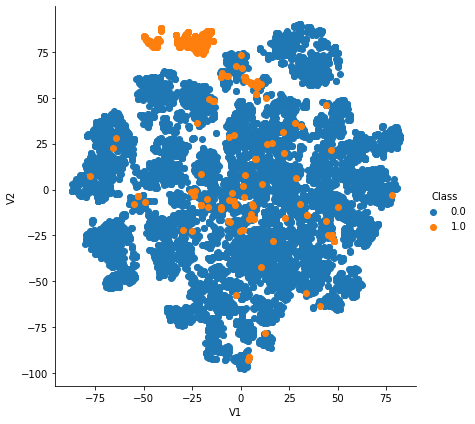

In [299]:
# Plots a pretty tsne plot 
tsne_plot = pd.DataFrame(data=tsne_plot, columns=("V1", "V2", "Class"))
sb.FacetGrid(tsne_plot, size=6, hue="Class").map(plt.scatter, "V1", "V2").add_legend()

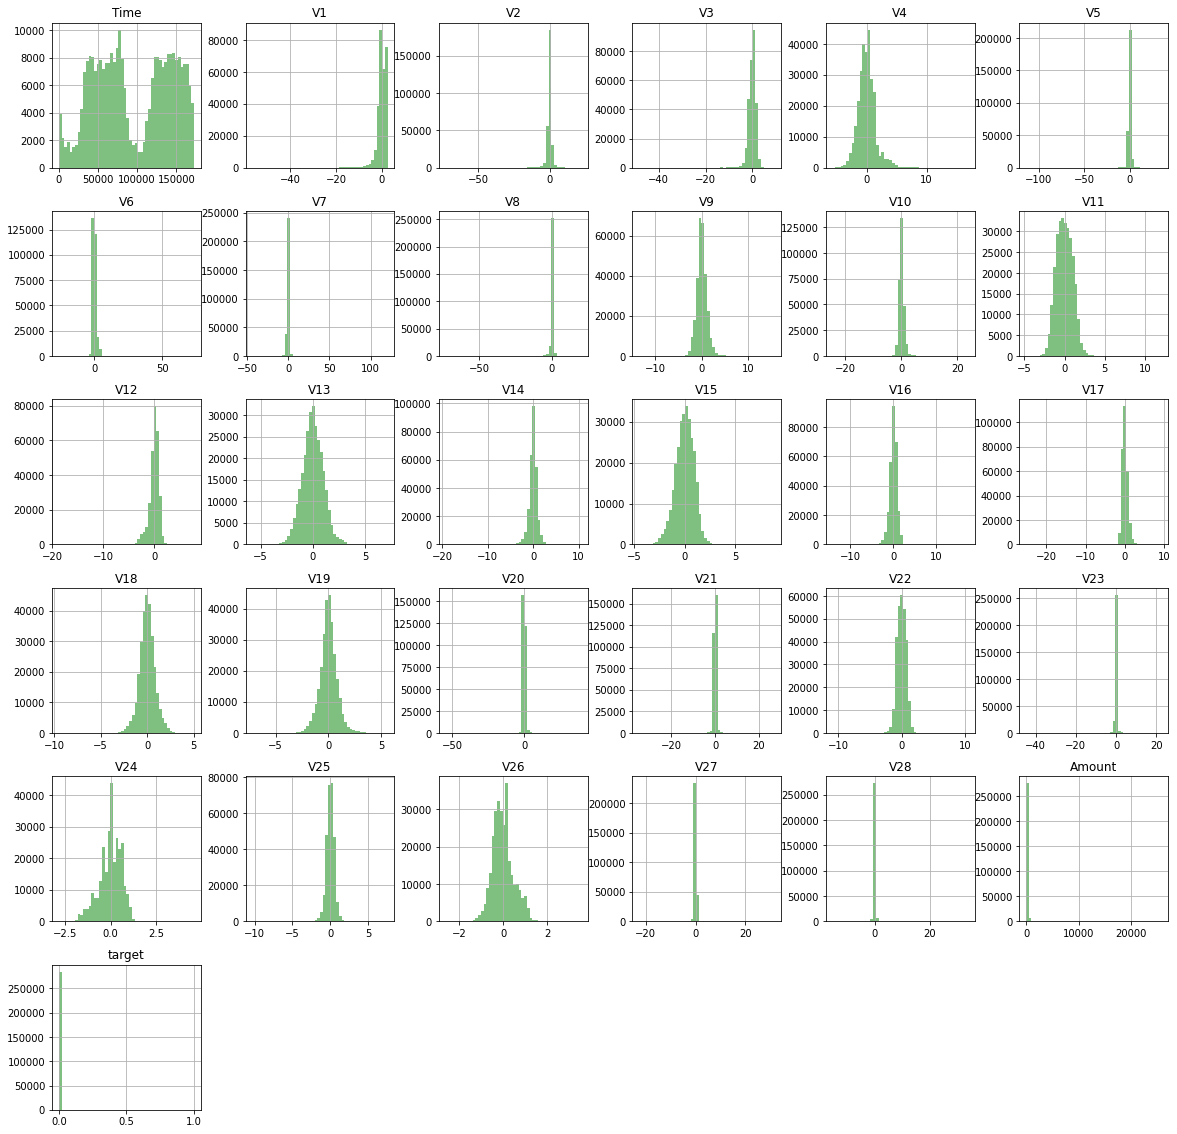

In [59]:
df.hist(figsize=(20,20), bins=50, color="green", alpha=0.5)
plt.show()

In [332]:
# Split data, including fraud in train set
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.2, random_state=1)
# Split data, but this time put all fraud in test set and only include normal in train
U_train = X_train[y_train == 0]
v_train = y_train[y_train == 0]
U_test = X_test.append(X_train[y_train == 1])
v_test = y_test.append(y_train[y_train == 1])
# Compute computation in test set
cntm = len(v_test[v_test==1])/len(v_test)

print(len(v_test[v_test==1]))
print(len(v_test[v_test==0]))

print(len(v_train[v_train==1]))
print(len(v_train[v_train==0]))
print(cntm)

492
56875
0
227440
0.008576359230916729


In [346]:
mdl = IsolationForest(n_estimators = 100, max_samples=1000, random_state=1, contamination = n_pos/(n_pos+n_neg))
mdl.fit(X_train, y_train)

mdl2 = IsolationForest(n_estimators = 100, max_samples=1000, random_state=1, contamination = cntm)
mdl2.fit(X_train, y_train)

IsolationForest(contamination=0.008576359230916729, max_samples=1000,
                random_state=1)

In [347]:
y_score = pd.DataFrame(mdl.decision_function(X_test), columns=['dec_score'])

v_score = pd.DataFrame(mdl2.decision_function(U_test), columns=['dec_score'])

In [348]:
y_pred = pd.DataFrame(mdl.predict(X_test), columns=["pred"])
y_pred[y_pred['pred'] == 1] = 0
y_pred[y_pred['pred'] == -1] = 1

v_pred = pd.DataFrame(mdl.predict(U_test), columns=["pred"])
v_pred[v_pred['pred'] == 1] = 0
v_pred[v_pred['pred'] == -1] = 1

In [349]:
precision,recall,fbeta_score, support  = prfs(y_test, y_pred, average='binary')
print("precision ", round((precision), 4))
print("recall ", round((recall), 4))
print("F1 score on Test", round((fbeta_score), 4))

precision  0.3049
recall  0.2874
F1 score on Test 0.2959


In [350]:
precision,recall,fbeta_score, support  = prfs(v_test, v_pred, average='binary')
print("Positives only in test set:")
print("precision ", round((precision), 4))
print("recall ", round((recall), 4))
print("F1 score on Test", round((fbeta_score), 4))
# Notable improvement when excluding F1 from train

Positives only in test set:
precision  0.7421
recall  0.3333
F1 score on Test 0.46
